В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [409]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import joblib

In [410]:
od.__version__

'0.1.22'

In [411]:
# 0

dataset_url= 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3/data'

In [412]:
od.download(dataset_url)

Skipping, found downloaded files in ".\bank-customer-churn-prediction-dlu-course-c-3" (use force=True to force download)


In [413]:
data_dir = 'bank-customer-churn-prediction-dlu-course-c-3'

In [414]:
os.listdir(data_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [415]:
# 1

train_csv = data_dir + '/train.csv'
raw_train = pd.read_csv(train_csv)

In [416]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [417]:
raw_train.Gender.value_counts(normalize=True)

Gender
Male      0.5686
Female    0.4314
Name: proportion, dtype: float64

In [418]:
raw_train.Geography.value_counts(normalize=True)

Geography
France     0.602133
Spain      0.220200
Germany    0.177667
Name: proportion, dtype: float64

In [419]:
# Видалимо ID клієнта за умовами завдання, а також прізвище як неінформативну ознаку
raw_train_wo_id_surname = raw_train.drop(['CustomerId', 'Surname'], axis=1)
raw_train_wo_id_surname.sample(5)

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
999,999,602.0,Germany,Female,52.0,6.0,131834.76,1.0,1.0,0.0,84584.69,1.0
5592,5592,648.0,France,Female,56.0,4.0,103891.47,1.0,1.0,0.0,151871.84,1.0
4635,4635,729.0,France,Female,33.0,3.0,0.00,1.0,1.0,0.0,82867.55,0.0
11162,11162,735.0,France,Male,31.0,6.0,0.00,2.0,1.0,1.0,123866.43,0.0
11729,11729,587.0,France,Male,30.0,5.0,0.00,2.0,0.0,0.0,133871.83,0.0


In [420]:
'''from imblearn.under_sampling import RandomUnderSampler
rand_samp = RandomUnderSampler()
X_resampled = rand_samp.fit_resample(raw_train_wo_id_surname, raw_train_wo_id_surname['Exited'])
'''

"from imblearn.under_sampling import RandomUnderSampler\nrand_samp = RandomUnderSampler()\nX_resampled = rand_samp.fit_resample(raw_train_wo_id_surname, raw_train_wo_id_surname['Exited'])\n"

In [421]:
# Поділимо train
train_df, val_df = train_test_split(raw_train_wo_id_surname, test_size=0.25, random_state=42)
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (11250, 12)
val_df.shape : (3750, 12)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [422]:
# 2
input_cols = list(train_df.columns)[1:-1]
target_col = list(train_df.columns)[-1]
print(input_cols,'\n', target_col)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'] 
 Exited


In [423]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [424]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

**4. Відповідь**

1. На самому початку я видалила Customer ID - як було вказано в завданні. А також видалила стовпець Surname, який по суті дублює Customer ID і не є інформативним для моделі.
2. Категоріальні закодую за допомогою OneHotEnkoder - Geography, в ознаках лище 3 значення. Gender перетворю на бінарну числову ознаку.
3. Перевірю наявність пропущених значень
4. Числові виглядають непогано. Проаналізую Balance, є ідея окремо визначати тих, у кого є грошові залишки.


In [425]:
# 2
# Закодуємо Gender
Gender_codes = {'Female': 0, 'Male': 1}
train_inputs['Gender_codes'] = train_inputs.Gender.map(Gender_codes)
val_inputs['Gender_codes'] = val_inputs.Gender.map(Gender_codes)

In [426]:
# Закодуємо Geography
enc = preprocessing.OneHotEncoder()
enc.fit(train_inputs[['Geography']])
print(enc.categories_)
one_hot_train = enc.transform(train_inputs[['Geography']]).toarray()
one_hot_val = enc.transform(val_inputs[['Geography']]).toarray()
train_inputs[enc.categories_[0]] = one_hot_train
val_inputs[enc.categories_[0]] = one_hot_val
val_inputs.head(5)


[array(['France', 'Germany', 'Spain'], dtype=object)]


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_codes,France,Germany,Spain
11499,656.0,Germany,Male,36.0,2.0,81370.07,2.0,0.0,1.0,116469.19,1,0.0,1.0,0.0
6475,602.0,France,Male,63.0,5.0,92466.21,1.0,1.0,0.0,176913.42,1,1.0,0.0,0.0
13167,687.0,Germany,Male,33.0,6.0,125845.66,2.0,1.0,0.0,147963.07,1,0.0,1.0,0.0
862,580.0,France,Male,46.0,1.0,126576.62,1.0,0.0,0.0,172450.04,1,1.0,0.0,0.0
5970,683.0,Spain,Female,35.0,4.0,162442.35,1.0,1.0,1.0,96498.14,0,0.0,0.0,1.0


In [427]:
# 3
train_inputs.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Gender_codes       0
France             0
Germany            0
Spain              0
dtype: int64

Пропущених значень немає. Але вони можуть бути

In [428]:
# 4
# Перевіримо числові стовпці на адекватність значень
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,659.70,37.72,5.01,42289.10,1.60,0.79,0.49,117881.64
std,72.47,8.22,2.78,59506.53,0.54,0.41,0.50,45741.40
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,604.00,32.00,3.00,0.00,1.00,1.00,0.00,83085.03
50%,663.00,37.00,5.00,0.00,2.00,1.00,0.00,123587.83
75%,709.00,42.00,7.00,108902.95,2.00,1.00,1.00,157097.09
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


Всі числові ознаки виглядаюсь непогано. Окрім стовпця Balance - здається, что розподіл зміщений правочруч, тому що багато 0 значень. Проаналізуємо ознаку. В середній зарплаті є викиди, треба теж проаналізувати

In [429]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

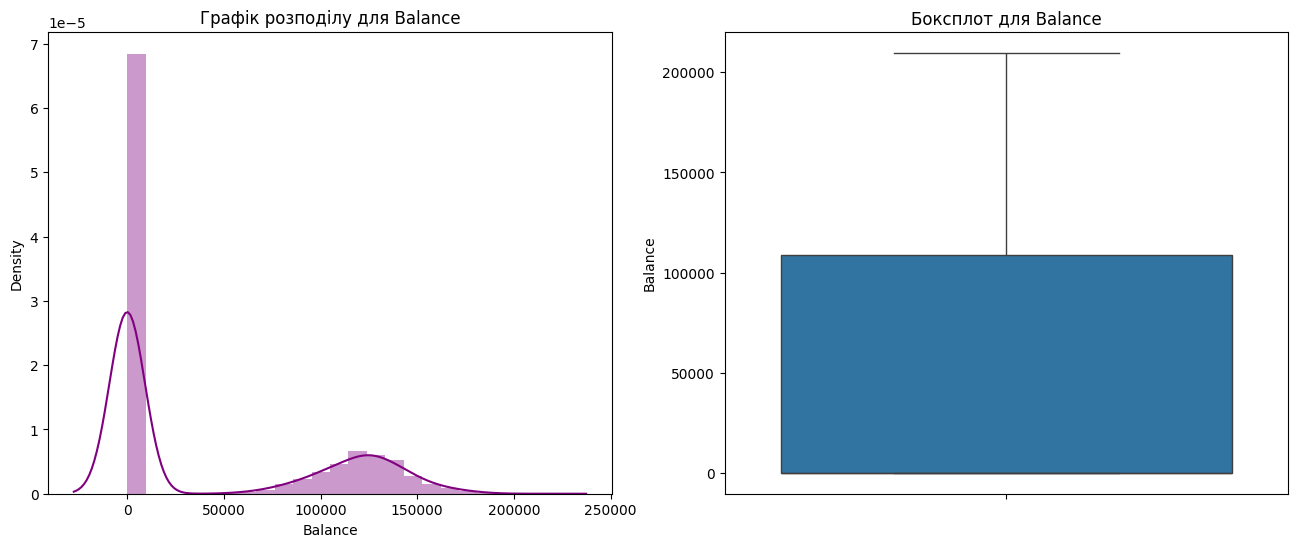

In [430]:
# Візуалізуємо та проаналізуємо Balance
dist_box(train_inputs, 'Balance')

In [431]:
train_inputs.Balance.value_counts().sort_index()

Balance
0.00         7343
51116.26        1
51522.75        2
53772.73        1
54980.81        1
             ... 
185966.64       1
186796.37       1
187530.66       1
187841.99       1
209767.31       1
Name: count, Length: 2765, dtype: int64

In [432]:
# Додамо бінарну числову ознаку - є залишок грошей на балансі чи ні.
train_inputs['Balance_codes'] = train_inputs.Balance.map(lambda x: 0 if x==0 else 1)
val_inputs['Balance_codes'] = val_inputs.Balance.map(lambda x: 0 if x==0 else 1)

In [433]:
# Масштабуємо числові ознаки
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,0.55,0.35,0.50,0.20,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.28,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.79
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [434]:
# Результат обробки
pd.set_option('display.max_columns', None)
display(train_inputs.head(5), val_inputs.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_codes,France,Germany,Spain,Balance_codes
7410,0.568019,Germany,Female,0.196429,0.6,0.600483,0.333333,1.0,0.0,0.794453,0,0.0,1.0,0.0,1
10894,0.923628,France,Male,0.178571,0.7,0.000000,0.333333,1.0,0.0,0.514536,1,1.0,0.0,0.0,0
1934,0.381862,France,Female,0.285714,0.7,0.000000,0.333333,1.0,1.0,0.604264,0,1.0,0.0,0.0,0
11539,0.293556,Spain,Male,0.303571,0.3,0.000000,0.333333,1.0,1.0,0.049869,1,0.0,0.0,1.0,0
2952,0.553699,Spain,Male,0.375000,0.8,0.000000,0.333333,1.0,0.0,0.619911,1,0.0,0.0,1.0,0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_codes,France,Germany,Spain,Balance_codes
11499,0.536993,Germany,Male,0.321429,0.2,0.387906,0.333333,0.0,1.0,0.582344,1,0.0,1.0,0.0,1
6475,0.408115,France,Male,0.803571,0.5,0.440804,0.000000,1.0,0.0,0.884594,1,1.0,0.0,0.0,1
13167,0.610979,Germany,Male,0.267857,0.6,0.599930,0.333333,1.0,0.0,0.739828,1,0.0,1.0,0.0,1
862,0.355609,France,Male,0.500000,0.1,0.603414,0.000000,0.0,0.0,0.862275,1,1.0,0.0,0.0,1
5970,0.601432,Spain,Female,0.303571,0.4,0.774393,0.000000,1.0,1.0,0.482479,0,0.0,0.0,1.0,1


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [435]:
# 5
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 15)
train_targets: (11250,)
val_inputs: (3750, 15)
val_targets: (3750,)


In [436]:
train_inputs.to_parquet('D:/DS_UA/2_2 Logistic regression/HW/train_inputs.parquet')
val_inputs.to_parquet('D:/DS_UA/2_2 Logistic regression/HW/val_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('D:/DS_UA/2_2 Logistic regression/HW/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('D:/DS_UA/2_2 Logistic regression/HW/val_targets.parquet')
os.listdir()

['bank-customer-churn-prediction-dlu-course-c-3',
 'estimation_of_obesity_levels_based_on_eating_habits_and_physical.csv',
 'exited_clients.joblib',
 'HW_2_2_Логістична_регресія_з_scikit_learn.ipynb',
 'HW_2_2_Логістична_регресія_з_scikit_learn_LI.ipynb',
 'HW_2_2_Логістична_регресія_з_scikit_learn_LI2.ipynb',
 'HW_2_2_Логістична_регресія_з_scikit_learn_LI3.ipynb',
 'HW_2_2_Математичне_формулювання_логістичної_регресії.ipynb',
 'HW_2_2_Математичне_формулювання_логістичної_регресії_LI.ipynb',
 'HW_2_2_Математичне_формулювання_логістичної_регресії_Solution.ipynb',
 'regression_data.csv',
 'submission_log_reg.csv',
 'submission_log_reg_1.csv',
 'submission_log_reg_2.csv',
 'The kaggle book.pdf',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet',
 'weather-dataset-rattle-package']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [437]:
# 6
all_col = train_inputs.columns.tolist()
all_col.remove('Geography')
all_col.remove('Gender')
#all_col.remove('Balance')
model_col = all_col
model_col

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Gender_codes',
 'France',
 'Germany',
 'Spain',
 'Balance_codes']

In [438]:
%%time

X_train = pd.read_parquet('train_inputs.parquet')[model_col]
X_val = pd.read_parquet('val_inputs.parquet')[model_col]

X_val.head()
#val_inputs = pd.read_parquet('val_inputs.parquet')

CPU times: total: 15.6 ms
Wall time: 25.9 ms


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_codes,France,Germany,Spain,Balance_codes
11499,0.536993,0.321429,0.2,0.387906,0.333333,0.0,1.0,0.582344,1,0.0,1.0,0.0,1
6475,0.408115,0.803571,0.5,0.440804,0.000000,1.0,0.0,0.884594,1,1.0,0.0,0.0,1
13167,0.610979,0.267857,0.6,0.599930,0.333333,1.0,0.0,0.739828,1,0.0,1.0,0.0,1
862,0.355609,0.500000,0.1,0.603414,0.000000,0.0,0.0,0.862275,1,1.0,0.0,0.0,1
5970,0.601432,0.303571,0.4,0.774393,0.000000,1.0,1.0,0.482479,0,0.0,0.0,1.0,1


In [439]:
#?LogisticRegression

In [440]:
# Тренуємо модель
weights = {0: 1, 1: 4}
model = LogisticRegression(solver='liblinear', class_weight=weights)
model.fit(X_train, train_targets)
print(model.coef_.tolist())
print(model.intercept_)

[[-0.6364357700801029, 9.125936728585447, -0.16891297520698545, 0.041801447257104496, -3.0907620975350234, -0.1463987915128424, -1.1578004837421656, 0.21300215429527514, -0.8386097935742727, -0.8480572337569987, 0.6896634940785422, -0.9423111370444842, -0.4830707427035317]]
[-1.10070488]


In [441]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
train_probs = model.predict_proba(X_train)
val_probs = model.predict_proba(X_val)
#train_probs[:10], val_probs[:10]

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [442]:
accuracy_train = accuracy_score(train_targets, train_preds)
accuracy_val = accuracy_score(val_targets, val_preds)
print(accuracy_train, accuracy_val)
train_targets.value_counts()
# Оцінка виглядає непогано, але вибірка незбалансована, значень класа 1 в 4 рази меньше, ніж значень класу 0. Не треба використовувати її в цьому випадку

0.8216 0.8181333333333334


Exited
0.0    8984
1.0    2266
Name: count, dtype: int64

In [443]:
# Виводимо Confusion matrix
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.8254675 , 0.1745325 ],
       [0.19373345, 0.80626655]])

In [444]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 82.16%


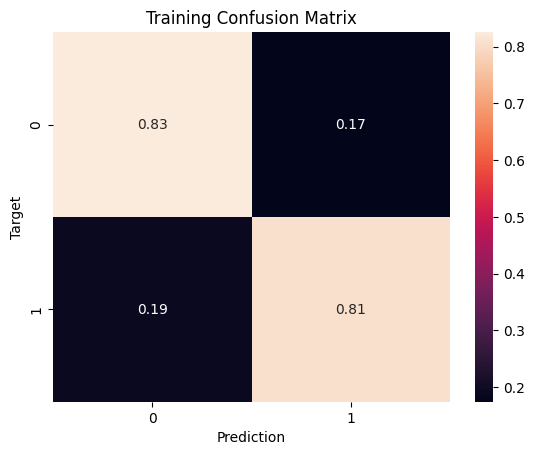

In [445]:
# Візуалізуємо матрицю для обох наборів
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 81.81%


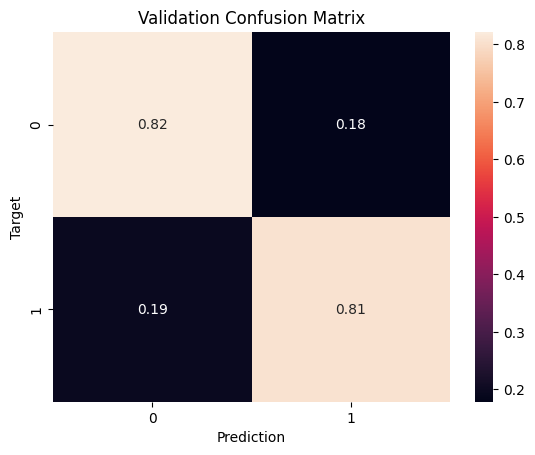

In [446]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

In [447]:
f1_train = f1_score(train_targets, train_preds)
f1_val = f1_score(val_targets, val_preds)
print('F1-score Train: ', round(f1_train,2))
print('F1-score Validation: ', round(f1_val,2))


F1-score Train:  0.65
F1-score Validation:  0.65


AUROC for Training: 0.88


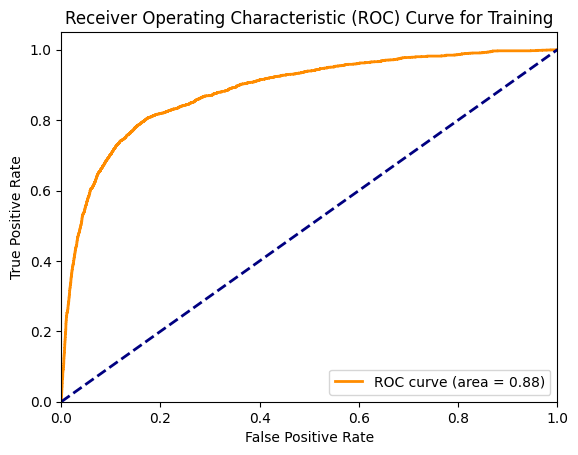

AUROC for Validation: 0.88


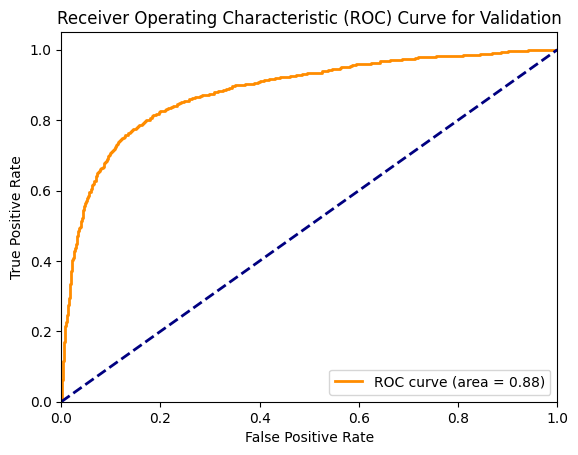

In [448]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

**7. Відповідь**

Згідно завдання задан рівень tresholda  - 0.5, тому оцінюємо модель по показнику F1. Треба сказати, що показники вибірки Validation дуже схожі на показники вибірки Train. F1 Validation - 0,64, Train - 0.63. Модель, здається непогана, але мало угадано TP та багато FN. Тобто мало разів передбачен позитивний результат взагалі. На це може сильно впливати несбаланованість класів у вибірці. З цім і треба працювати для покращення моделі.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [449]:
# 8
print(train_targets.value_counts())

def all_no(inputs):
    return np.full(len(inputs), 0)

# модель з п.6
accuracy_train = accuracy_score(train_targets, train_preds)
accuracy_val = accuracy_score(val_targets, val_preds)
# всі значення мажорітарного класу - 0
accuracy_train_0 = accuracy_score(train_targets, all_no(X_train))
accuracy_val_0 = accuracy_score(val_targets, all_no(X_val))

print(accuracy_train, accuracy_train_0)
print(accuracy_val, accuracy_val_0)

Exited
0.0    8984
1.0    2266
Name: count, dtype: int64
0.8216 0.7985777777777778
0.8181333333333334 0.7904


Як і передбачалось, модель на даних зі значеннями тільки мадоритеного класу (0) не набагато гірше нашої. Тобто для якісного прогнозування треба шукати способи покращщеня моделі.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [450]:
exited_clients = {
    'model': model,
    'scaler': scaler,
    'encoder': enc,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols
}
joblib.dump(exited_clients, 'exited_clients.joblib')

['exited_clients.joblib']

In [451]:
exited_clients2 = joblib.load('exited_clients.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [452]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df['Gender_codes'] = input_df.Gender.map(Gender_codes) # робимо числовою бінарною ознакою
    input_df[encoder.categories_[0]] = encoder.transform(input_df[['Geography']]).toarray() # кодуємо Geography
    input_df['Balance_codes'] = input_df.Balance.map(lambda x: 0 if x==0 else 1) # додаємо бінарну ознаку по залишкам на балансі
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    #input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[model_col]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [453]:
#model_col

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [454]:
# 11
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)

In [455]:
test_raw_df['Exited'] = predict_raw_df(scaler, enc, numeric_cols, categorical_cols, test_raw_df)
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_codes,France,Germany,Spain,Balance_codes,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,1,0.0,1.0,0.0,1,0.240438
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1,1.0,0.0,0.0,0,0.130730
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1,1.0,0.0,0.0,0,0.431479
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,1,0.0,0.0,1.0,0,0.476731
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,1,0.0,0.0,1.0,0,0.202837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,0.496420,Spain,Male,0.357143,1.0,0.000000,0.333333,1.0,1.0,0.248154,1,0.0,0.0,1.0,0,0.084030
9996,24996,15739271.0,Clements,0.589499,Spain,Male,0.375000,0.9,0.000000,0.333333,1.0,1.0,0.712578,1,0.0,0.0,1.0,0,0.102544
9997,24997,15756743.0,Chidiebere,0.818616,France,Male,0.214286,0.9,0.000000,0.333333,1.0,0.0,0.024253,1,1.0,0.0,0.0,0,0.064385
9998,24998,15680167.0,Yermakova,0.391408,France,Male,0.357143,0.6,0.690650,0.000000,1.0,0.0,0.632348,1,1.0,0.0,0.0,1,0.414724


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [456]:
sample_submission_csv = data_dir + '/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_csv)

In [457]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10000 non-null  int64  
 1   Exited  10000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 156.4 KB


In [458]:
sample_submission['Exited'] = sample_submission['id'].map(test_raw_df.set_index('id')['Exited'])
sample_submission.head(5)


,id,Exited
0,15000,0.240438
1,15001,0.130730
2,15002,0.431479
3,15003,0.476731
4,15004,0.202837


In [459]:
sample_submission.to_csv('D:/DS_UA/2_2 Logistic regression/HW/submission_log_reg.csv', index=False)